# Introduction to gimVI
## Impute missing genes in Spatial Data from Sequencing Data

In [11]:
import sys

sys.path.append("../../")
sys.path.append("../")

In [12]:
def allow_notebook_for_test():
    print("Testing the gimvi notebook")


test_mode = False
show_plot = True
save_path = "data/"


def if_not_test_else(x, y):
    if not test_mode:
        return x
    else:
        return y


if not test_mode:
    %matplotlib inline
    save_path = "../../data"

In [13]:
import scanpy
import anndata

from scvi.dataset import (
    prefrontalcortex_starmap,
    frontalcortex_dropseq,
    smfish,
    cortex,
    setup_anndata
)
from scvi.models import JVAE, Classifier
from scvi.inference import JVAETrainer

import notebooks.utils.gimvi_tutorial as gimvi_utils
import numpy as np
import copy

## Load two datasets: one with spatial data, one from sequencing

Here we load: 
- **Cortex**: a scRNA-seq dataset of 3,005 mouse somatosensory cortex cells (Zeisel et al., 2015)
- **osmFISH**: a smFISH dataset of 4,462 cells and 33 genes from the same tissue (Codeluppi et al., 2018)

In [4]:
data_spatial = smfish(save_path=save_path, use_high_level_cluster = True)
data_spatial.obs['batch'] = np.zeros(data_spatial.shape[0])

data_seq_labels_key = "labels"
data_spatial_labels_key = "labels"

data_seq_cell_type_key = 'cell_type'
data_spatial_cell_type_key = 'str_labels'

data_seq = cortex(save_path=save_path)
print('test_mode')
print(test_mode)
if test_mode:
    data_seq = data_spatial.copy()
    data_seq_labels_key = data_spatial_labels_key
    data_seq_cell_type_key = data_spatial_cell_type_key

[2020-07-13 22:05:56,939] INFO - scvi.dataset._utils | File /Users/galen/scVI/data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
[2020-07-13 22:05:56,940] INFO - scvi.dataset.smfish | Loading smFISH dataset
[2020-07-13 22:05:57,001] INFO - scvi.dataset._utils | File /Users/galen/scVI/data/expression.bin already downloaded
[2020-07-13 22:05:57,002] INFO - scvi.dataset.cortex | Loading Cortex data from /Users/galen/scVI/data/expression.bin
[2020-07-13 22:06:05,468] INFO - scvi.dataset.cortex | Finished loading Cortex data


/Users/galen/anaconda3/envs/scvi/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


- **FrontalCortexDropseq**: a scRNA-seq dataset of 71,639 mouse frontal cortex cells (Saunders et al., 2018)
- **PreFrontalCortexStarmap**: a starMAP dataset of 3,704 cells and 166 genes from the mouse pre-frontal cortex (Wang et al., 2018)


In [5]:
# data_spatial = prefrontalcortex_starmap(save_path=save_path)
# data_seq = frontalcortex_dropseq(save_path=save_path)

# data_seq_labels_key = 'Clusters'
# data_spatial_labels_key = 'labels'

# data_seq_cell_type_key = 'CellTypes'
# data_seq.obs[data_seq_cell_type_key] = [data_seq.uns['CellTypes'][i] for i in data_seq.obs['Clusters']]
# data_spatial_cell_type_key = 'labels'

# scanpy.pp.subsample(data_seq, n_obs = 5000)

**Hide some genes in the osFISH dataset to score the imputation**

In [6]:
data_seq = data_seq[:, data_spatial.var_names].copy()
scanpy.pp.filter_cells(data_spatial, min_counts= 1)
scanpy.pp.filter_cells(data_seq, min_counts = 1)

In [7]:
train_size = 0.8

gene_names_rnaseq = data_seq.var_names
np.random.seed(0)
n_genes = len(gene_names_rnaseq)
gene_ids_train = sorted(
    np.random.choice(range(n_genes), int(n_genes * train_size), False)
)
gene_ids_test = sorted(set(range(n_genes)) - set(gene_ids_train))

gene_names_fish = gene_names_rnaseq[gene_ids_train]

# Create copy of the fish dataset with hidden genes
data_spatial_partial = data_spatial.copy()
data_spatial_partial = data_spatial_partial[:, gene_names_fish].copy()

setup_anndata(data_seq, labels_key=data_seq_labels_key)
setup_anndata(data_spatial_partial,batch_key = 'batch', labels_key= data_spatial_labels_key )

data_spatial_partial.obs['_scvi_batch'] += data_seq.uns['scvi_summary_stats']['n_batch']

[2020-07-13 22:06:05,753] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-07-13 22:06:05,754] INFO - scvi.dataset._anndata | No batch_key inputted, assuming all cells are same batch
[2020-07-13 22:06:05,762] INFO - scvi.dataset._anndata | Using labels from adata.obs["labels"]
[2020-07-13 22:06:05,763] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-13 22:06:05,768] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 2996 cells, 33 genes, and 1 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
[2020-07-13 22:06:05,771] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-07-13 22:06:05,771] INFO - scvi.dataset._anndata | Using batches from adata.obs["batch"]
[2020-07-13 22:06:05,774] INFO - scvi.dataset._anndata | Using labels from adata.obs["labels"]
[2020-07-13 22:06:05,775] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-13 22:06:05,78

**Configure the Joint Model**
The joint model can take multiple datasets with potentially different observed genes. 
All dataset will be encoded and decoded with the union of all genes.
It requires:
- The gene mappings from each dataset to the common decoded vector:
    * *Eg: dataset1 has genes ['a', 'b'] and dataset2 has genes ['b', 'c'], then a possible output can be ['b', 'a', 'c'] such that the mappings are [1, 0] and [0, 2]*
    * *Usually, if the genes of dataset2 are included in dataset1, it is way more efficient to keep the order of dataset1 in the output and use `slice(None)` as a mapping for dataset1*
    
- The number of inputs (ie) number of genes in each dataset
- The distributions to use for the generative process: usually scRNA-seq is modelled with ZINB (because of technical dropout) and FISH with NB or even Poisson
- Whether to model the library size with a latent variable or use the observed value

In [8]:
datasets = [data_seq, data_spatial_partial]
generative_distributions = ["zinb", "nb"]
gene_mappings = [slice(None), np.array(gene_ids_train)]
n_inputs = [d.uns['scvi_summary_stats']['n_genes'] for d in datasets]
total_genes = data_seq.uns['scvi_summary_stats']['n_genes']
n_batches = sum([d.uns['scvi_summary_stats']['n_batch'] for d in datasets])

model_library_size = [True, False]

n_latent = 8
kappa = 1

In [9]:
import torch

torch.manual_seed(0)

model = JVAE(
    n_inputs,
    total_genes,
    gene_mappings,
    generative_distributions,
    model_library_size,
    n_layers_decoder_individual=0,
    n_layers_decoder_shared=0,
    n_layers_encoder_individual=1,
    n_layers_encoder_shared=1,
    dim_hidden_encoder=64,
    dim_hidden_decoder_shared=64,
    dropout_rate_encoder=0.2,
    dropout_rate_decoder=0.2,
    n_batch=n_batches,
    n_latent=n_latent,
)

discriminator = Classifier(n_latent, 32, 2, 3, logits=True)

trainer = JVAETrainer(model, discriminator, datasets, 0.95, frequency=1, kappa=kappa)

In [10]:
n_epochs = if_not_test_else(200, 1)
trainer.train(n_epochs=n_epochs)

In [11]:
latent_seq, latent_spatial = trainer.get_latent()

latent_representation = np.concatenate([latent_seq, latent_spatial])

latent_adata = anndata.AnnData(latent_representation)
latent_labels = (['seq'] * latent_seq.shape[0]) + (['spatial'] * latent_spatial.shape[0])
latent_adata.obs['labels'] = latent_labels

In [12]:
scanpy.pp.neighbors(latent_adata)
scanpy.tl.umap(latent_adata)

In [13]:
data_seq.obsm['X_umap'] = latent_adata.obsm['X_umap'][:data_seq.shape[0]]
data_spatial.obsm['X_umap'] = latent_adata.obsm['X_umap'][data_seq.shape[0]:]

In [14]:
scanpy.pl.umap(latent_adata, color = 'labels', show = show_plot)

NameError: name 'latent_adata' is not defined

In [ ]:
scanpy.pl.umap(data_seq, color = data_seq_cell_type_key, show = show_plot)


In [ ]:
scanpy.pl.umap(data_spatial, color = data_spatial_cell_type_key, show = show_plot)


In [17]:
gimvi_utils.imputation_score(trainer, data_spatial, gene_ids_test, True)

-0.015697035454556942

### Plot imputation for *LAMP5*, hidden in the training

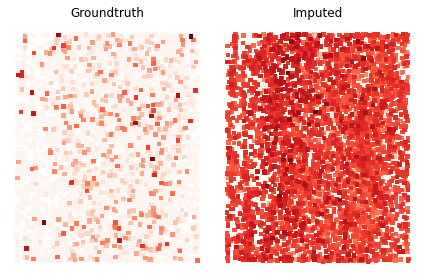

In [18]:
gimvi_utils.plot_gene_spatial(trainer, data_spatial, 9)

### Inspect classification accuracy (we expect a uniform matrix)
If the matrix is diagonal, the `kappa` needs to be scaled up to ensure mixing.

In [34]:
discriminator_classification = trainer.get_discriminator_confusion()
discriminator_classification

array([[0.4866517 , 0.5133502 ],
       [0.5067717 , 0.49322832]], dtype=float32)

In [35]:
import pandas as pd

results = pd.DataFrame(
    trainer.get_loss_magnitude(),
    index=["reconstruction", "kl_divergence", "discriminator"],
    columns=["Sequencing", "Spatial"],
)
results.columns.name = "Dataset"
results.index.name = "Loss"
results

Dataset,Sequencing,Spatial
Loss,,
reconstruction,29741.873959,85337.724319
kl_divergence,32446.235096,27534.217571
discriminator,389.413373,386.201046
